# Market Analysis

Instruments to trade: 0, 1, 2, 3, 4, 5, 6, 7, 22, 23, 24, 26, 27

---

We can first start by plotting all the instrument's price data to get a general overview

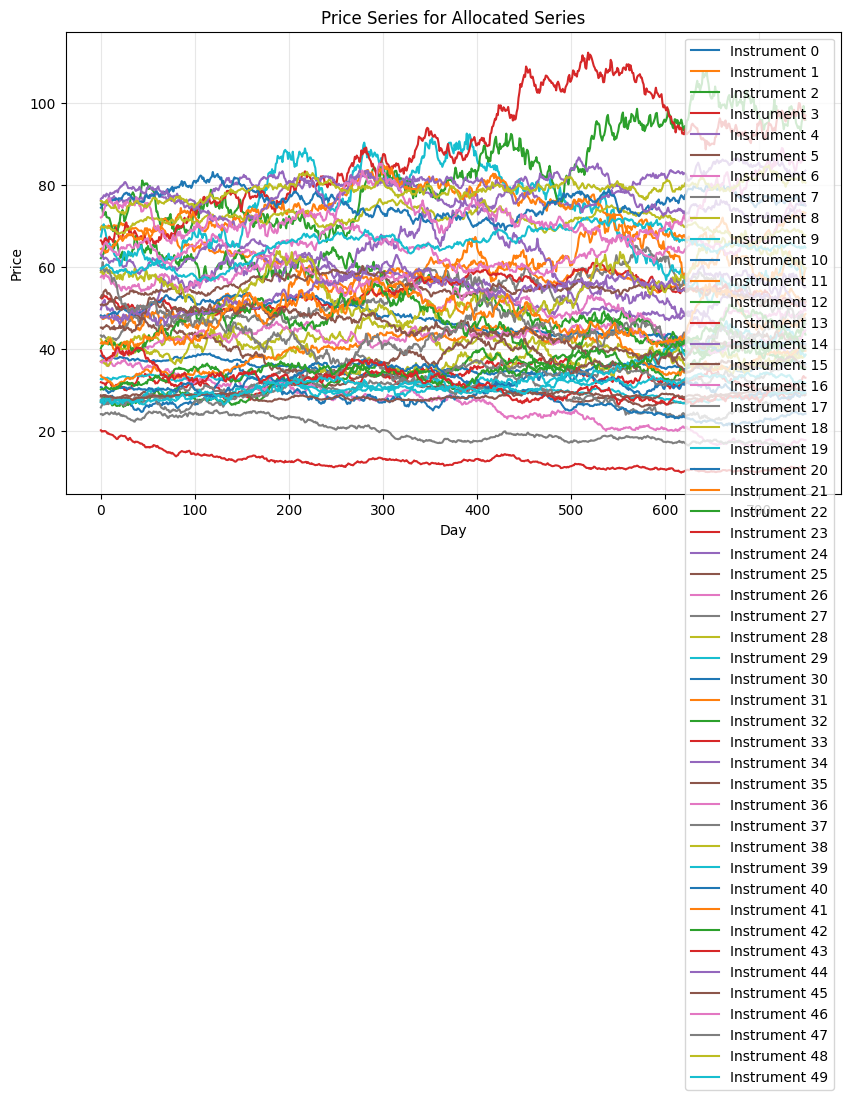

In [38]:
import matplotlib.pyplot as plt
from pandas import DataFrame
import pandas as pd
from typing import List

prices_filepath: str = "../prices.txt"
start_day: int = 0
end_day: int = 750
instrument_nos: List[int] = []
for i in range(0,50): instrument_nos.append(i)

def plot_price_data_all() -> None:
    # Read the csv
    raw_prices: DataFrame = pd.read_csv(prices_filepath, sep=r"\s+", header=None)
    raw_prices.index.name = "day"
    raw_prices.columns = raw_prices.columns.astype(int)
    
    my_instruments: DataFrame = raw_prices[instrument_nos]
    
    plt.figure(figsize=(10,6))
    for instrument in instrument_nos:
        plt.plot(my_instruments.index, my_instruments[instrument], label=f"Instrument {instrument}")
        
    plt.xlabel("Day")
    plt.ylabel("Price")
    plt.title("Price Series for Allocated Series")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_price_data_all()

It's also wise to calculate the maximum theoretical profit for our test timeline (0 - 500 days), 
and we aim
 to 
meet 
60-70% of this 
number.

In [39]:
from analysis import MarketData
prices_file_path: str = "../prices.txt"

market_data: MarketData = MarketData(0, 749, prices_filepath)
maximum_value: float = market_data.get_maximum_theoretical_value(instrument_nos, 0, 500)

print(f"Maximum theoretical value: ${maximum_value:.2f}")
print(f"60% of maximum theoretical value: ${(maximum_value * 0.6):.2f}")
print(f"70% of maximum theoretical value: ${(maximum_value * 0.7):.2f}")

Maximum theoretical value: $1860881.38
60% of maximum theoretical value: $1116528.83
70% of maximum theoretical value: $1302616.97


We aim to analyse each of the instruments and identify which follow Geometric Brownian 
Motion-like or Ornstein Uhlenbeck-like dynamics.

First we compute the log returns

In [40]:
from numpy import ndarray
import numpy as np
from typing import Dict

# 1. Compute Log Returns
raw_prices: DataFrame = pd.read_csv("../prices.txt", sep=r"\s+", header=None, index_col=None)
price_history: ndarray = raw_prices.values[:500][:].T

log_returns: Dict[int, ndarray] = {} 
for instrument_no in instrument_nos:
	log_returns[instrument_no] = np.array([np.log(price_history[instrument_no][i] / 
          price_history[instrument_no][i - 1]) for i in range(1, 500)])

Secondly, we perform an augmented Dickey-Fuller test to test for stationarity. This will tell us 
if the asset is trending or mean-reverting.

In [41]:
from statsmodels.tsa.stattools import adfuller

# Perform an ADF test on each instrument and print the result
adf_results: Dict[str, List[float | int]] = {}
adf_results["Instrument No"] = instrument_nos
adf_results["T Statistic"] = []
adf_results["P-Value"] = []

for instrument_no in instrument_nos:
	result = adfuller(price_history[instrument_no], autolag="AIC")
	adf_results["T Statistic"].append(result[0])
	adf_results["P-Value"].append(result[1])

adf_results_df: DataFrame = pd.DataFrame(adf_results)
print(adf_results_df.to_string(index=False))

 Instrument No  T Statistic  P-Value
             0    -1.252375 0.650670
             1    -1.617448 0.474067
             2    -1.046791 0.735818
             3    -1.481503 0.542641
             4    -0.520712 0.887911
             5    -0.945357 0.772669
             6    -1.455952 0.555178
             7    -1.880462 0.341308
             8    -2.498105 0.115936
             9    -1.288490 0.634422
            10    -1.249653 0.651880
            11    -1.401243 0.581680
            12    -0.883784 0.793266
            13    -0.672417 0.853765
            14    -1.500742 0.533144
            15    -2.401298 0.141370
            16    -0.867753 0.798406
            17    -1.482201 0.542297
            18    -3.403447 0.010842
            19    -1.116893 0.708288
            20    -0.078384 0.951550
            21    -1.279840 0.638344
            22    -1.692704 0.434875
            23    -0.520740 0.887905
            24    -1.652114 0.455938
            25    -2.425256 0.134735
 

As it can be seen above, each instrument gave a p-value greater than 0.05, concluding that they 
are all non-stationary except for instrument 26

Now we compute the following features: drift, volatility and autocorrelation 

In [42]:
instrument_features: Dict[str, List[float | int]] = {}
instrument_features["Instrument No."] = instrument_nos
instrument_features["Drift"] = []
instrument_features["Volatility"] = []

for instrument_no in instrument_nos:
	# 1. Calculate Drift
	drift: float = np.sum(log_returns[instrument_no] / 499)
	instrument_features["Drift"].append(drift)
	
	# 2. Calculate Volatility
	delta: ndarray = log_returns[instrument_no] - drift 
	sum_of_squares: float = np.sum(delta ** 2)
	volatility: float = np.sqrt(sum_of_squares / 498) 
	instrument_features["Volatility"].append(volatility)
	
instrument_features_df: DataFrame = pd.DataFrame(instrument_features)
print(instrument_features_df.to_string(index=False))

 Instrument No.     Drift  Volatility
              0 -0.000228    0.004519
              1 -0.000363    0.005948
              2 -0.000560    0.013080
              3  0.000267    0.011308
              4 -0.000418    0.006806
              5 -0.000055    0.005738
              6 -0.000840    0.011299
              7  0.000462    0.011059
              8 -0.000258    0.013707
              9  0.000217    0.012815
             10  0.000389    0.012397
             11  0.000458    0.012851
             12  0.000654    0.010791
             13  0.000183    0.005912
             14  0.000160    0.012205
             15  0.000150    0.005333
             16 -0.000381    0.009394
             17  0.000506    0.009266
             18  0.000321    0.010777
             19 -0.000213    0.005164
             20 -0.000192    0.004867
             21  0.000475    0.008128
             22  0.000210    0.013428
             23  0.000920    0.009685
             24 -0.000052    0.005514
            

We also plot a histogram of the returns to see if returns are distributed normally

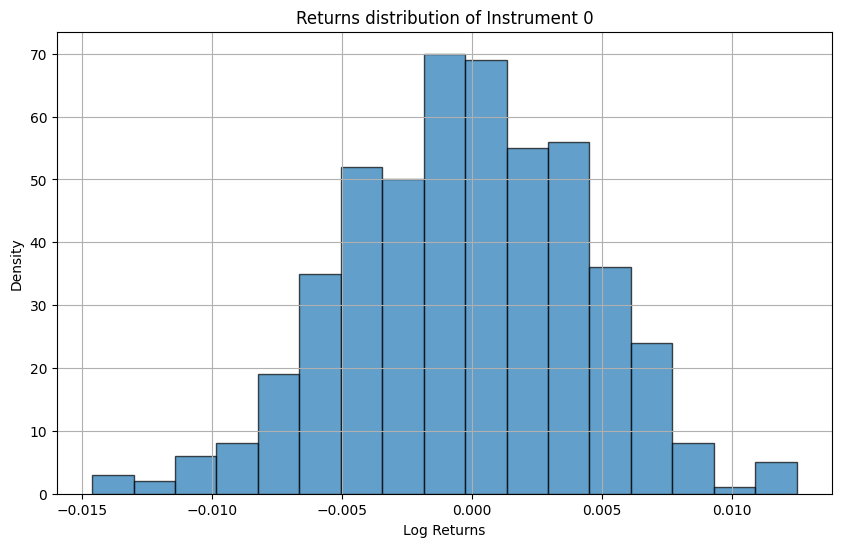

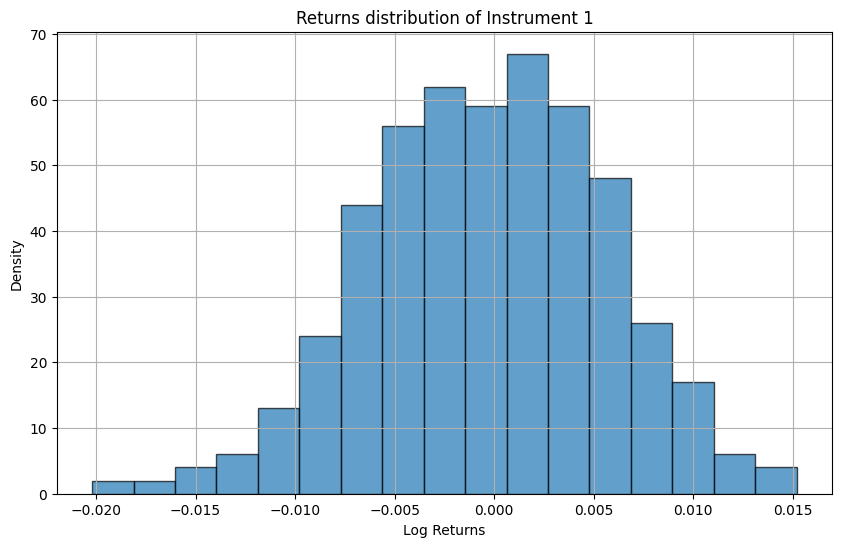

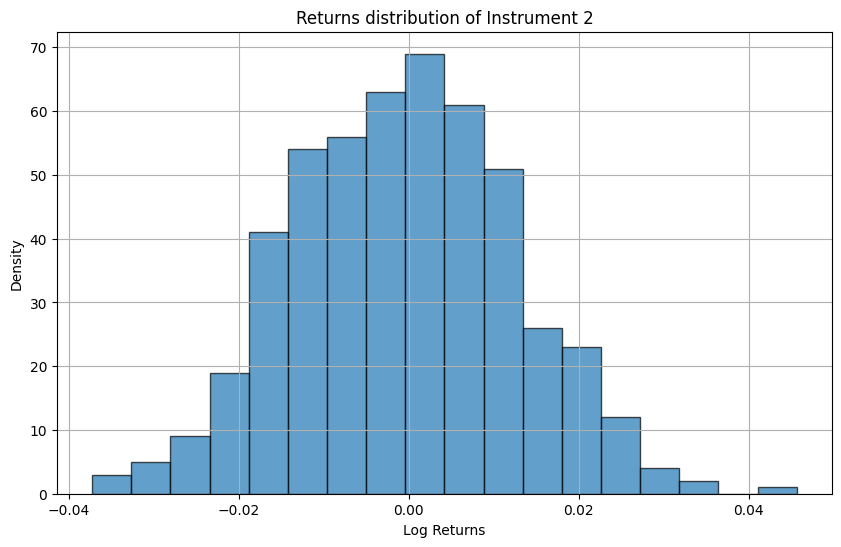

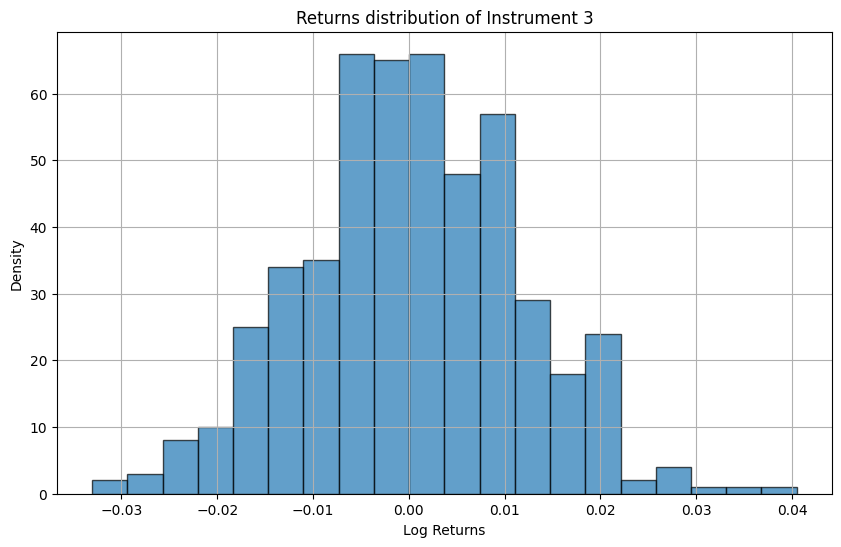

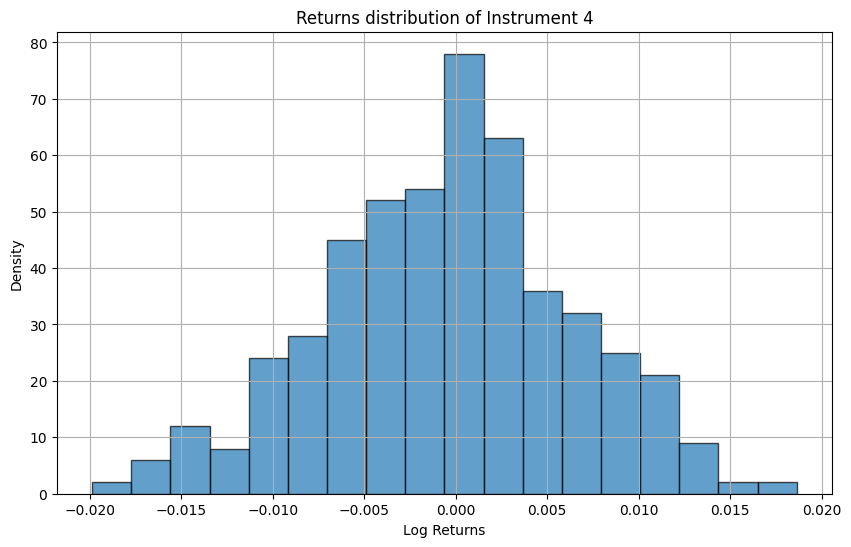

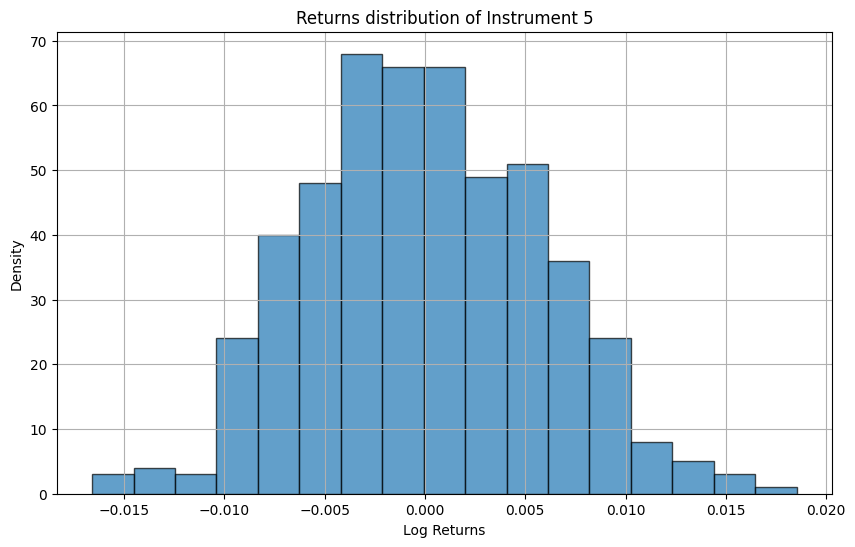

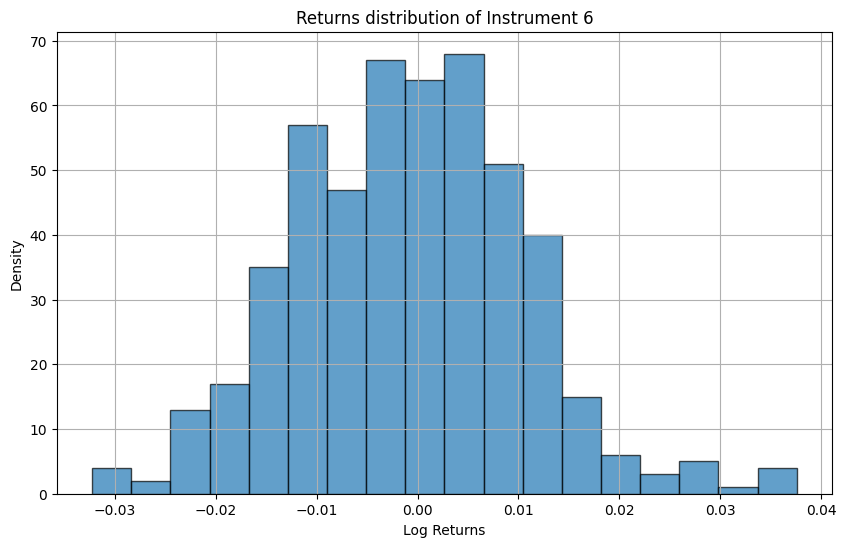

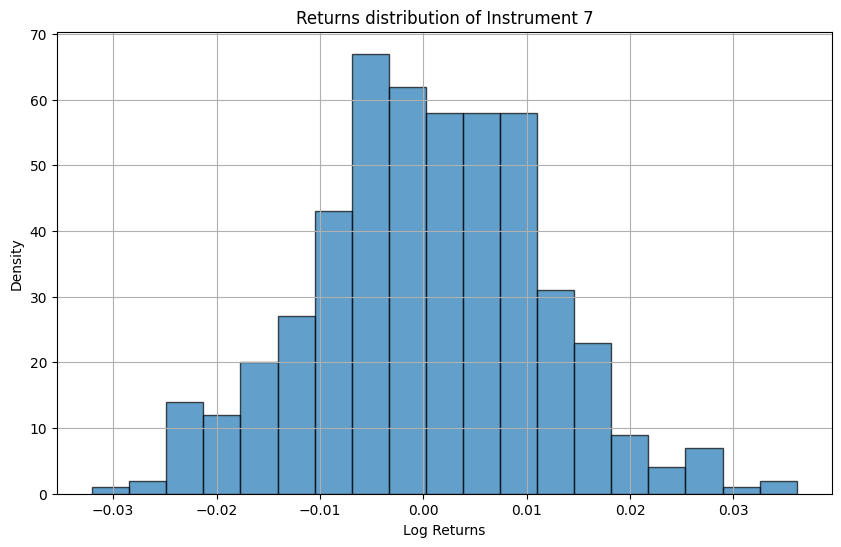

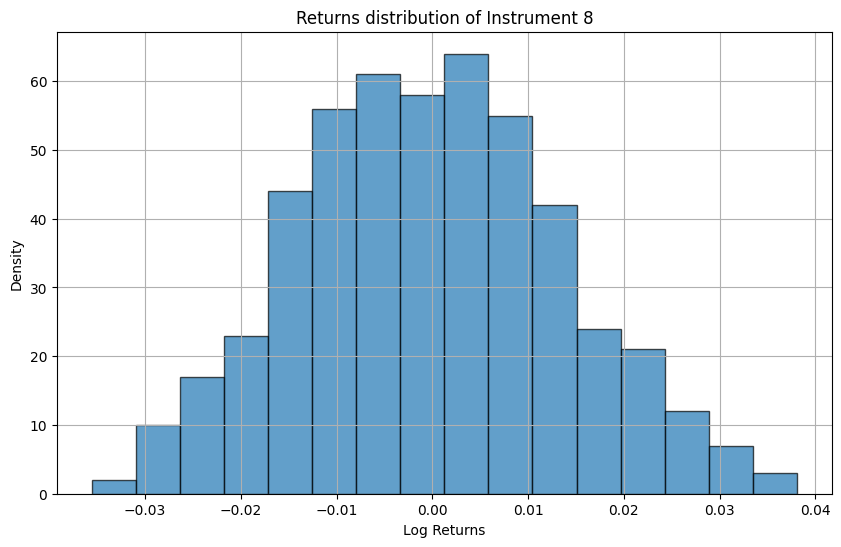

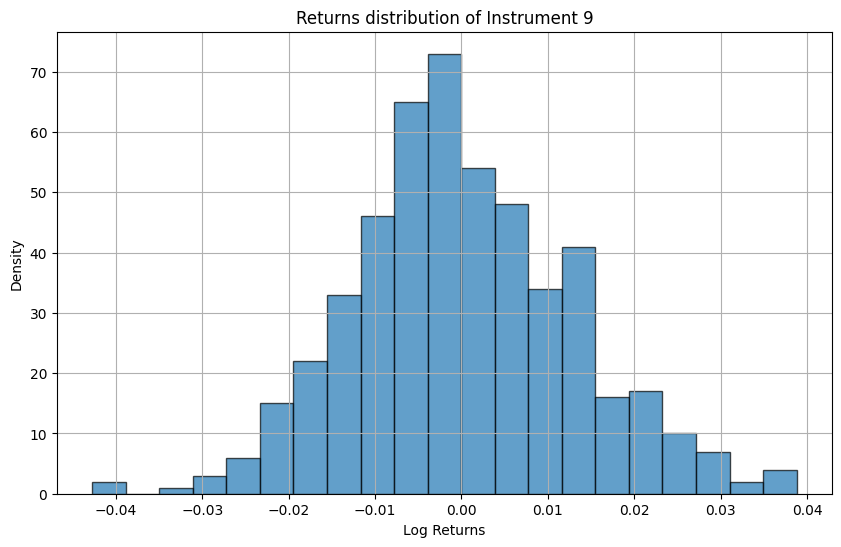

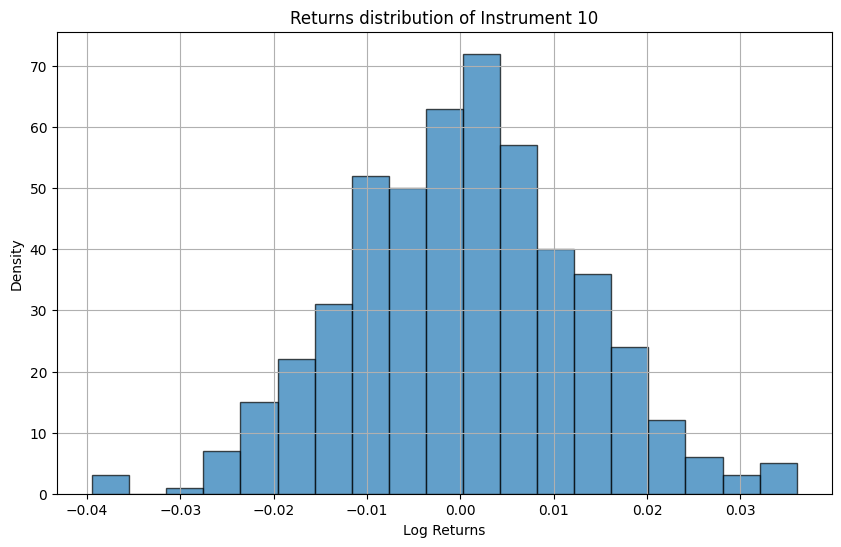

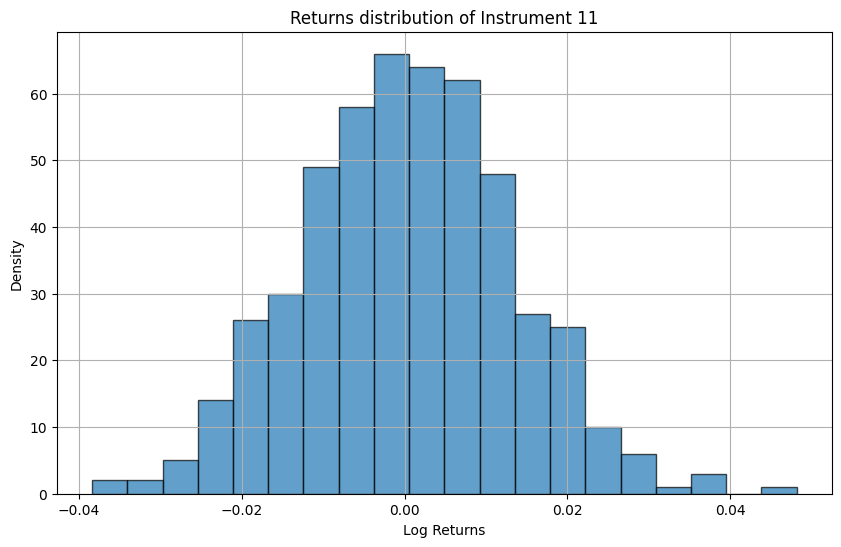

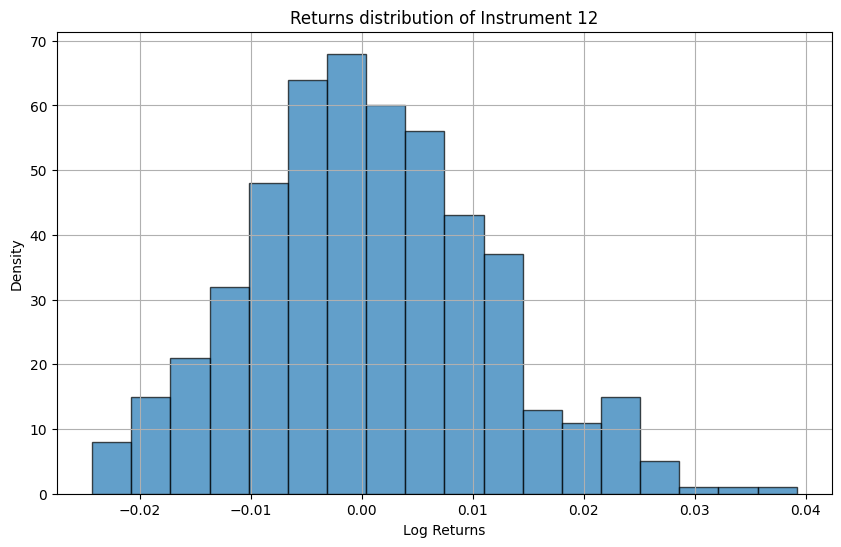

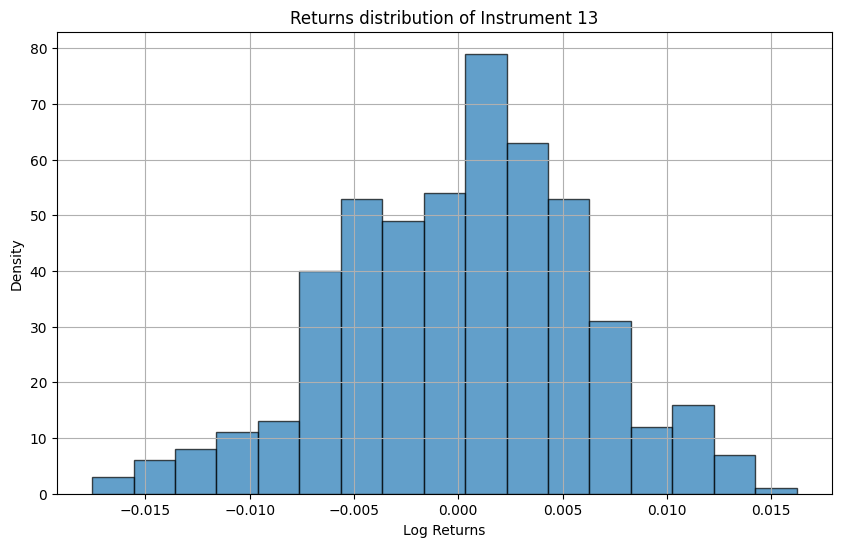

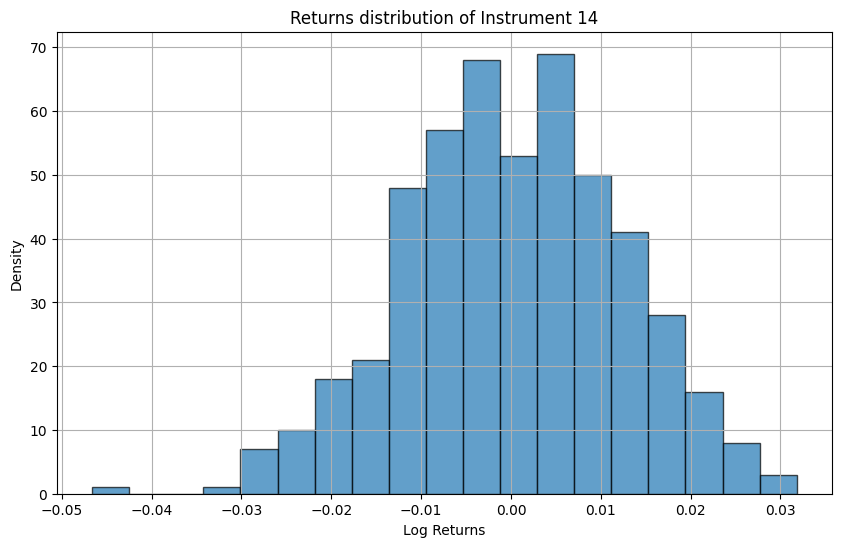

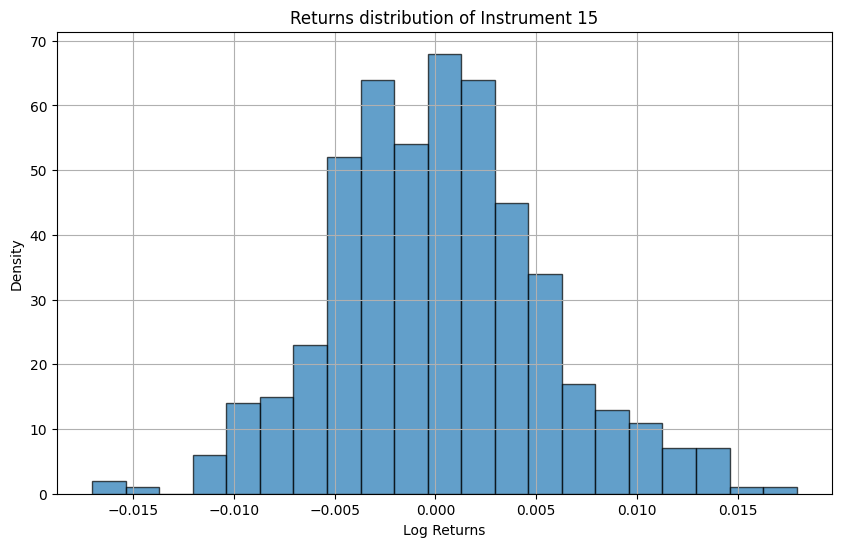

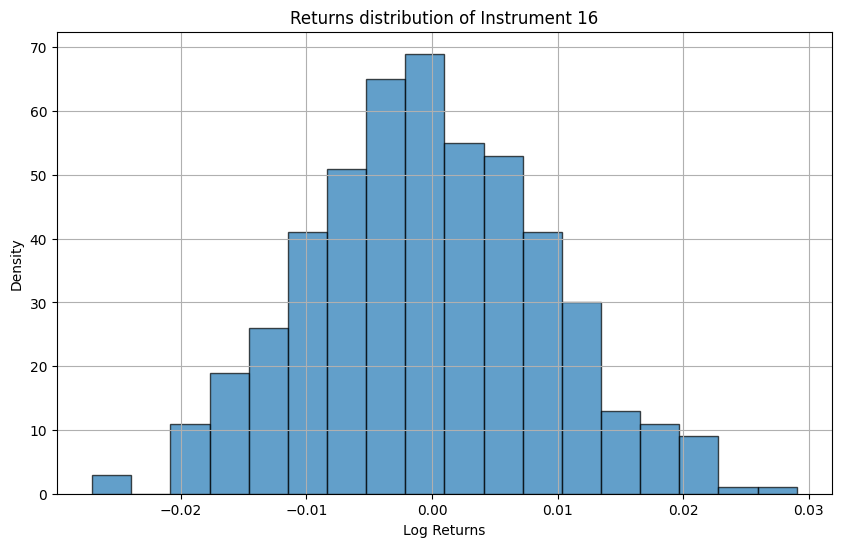

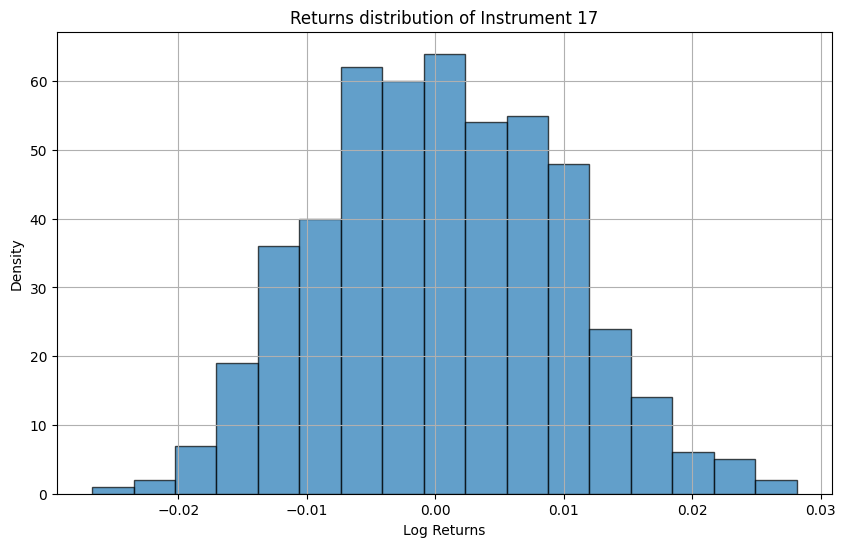

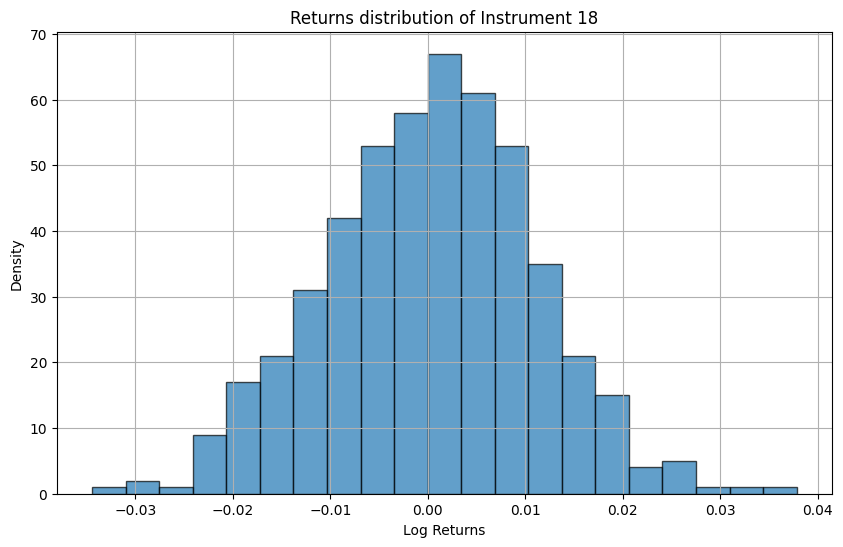

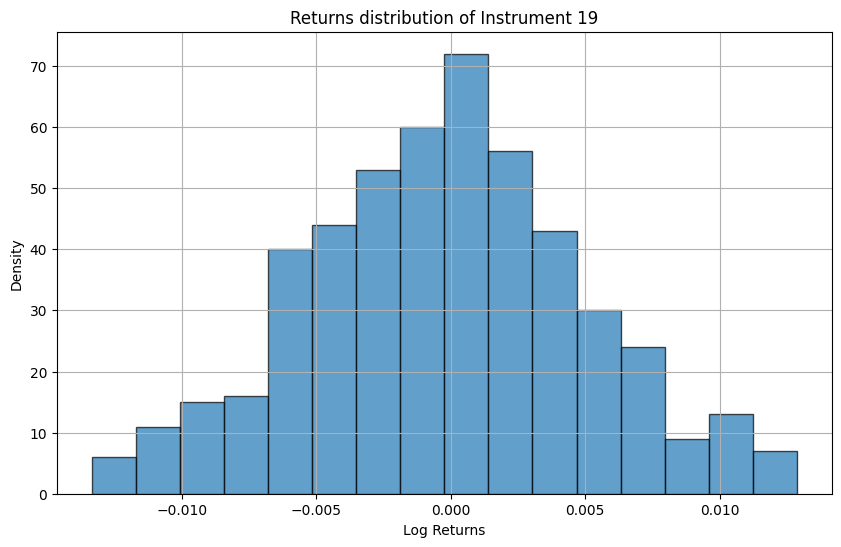

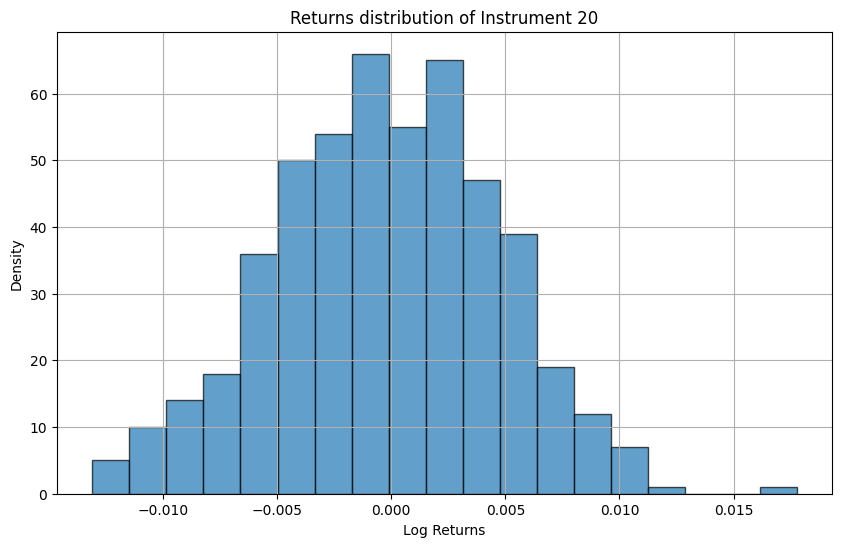

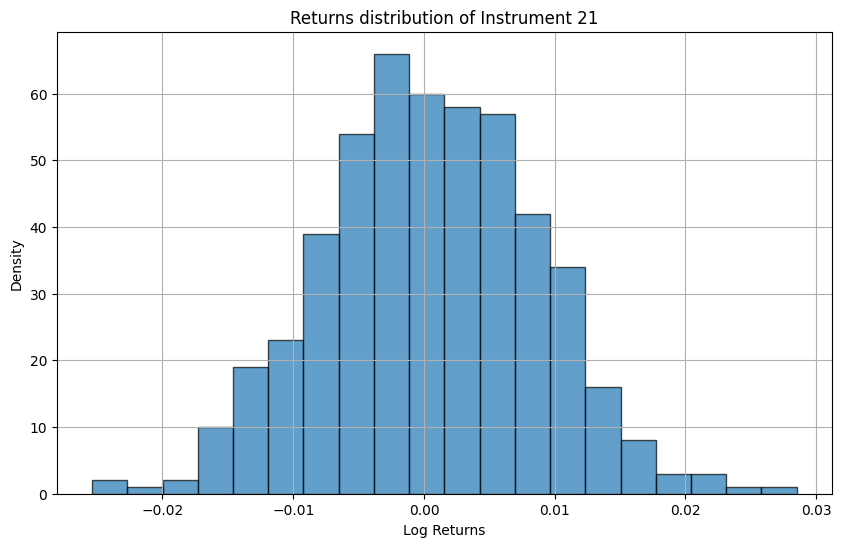

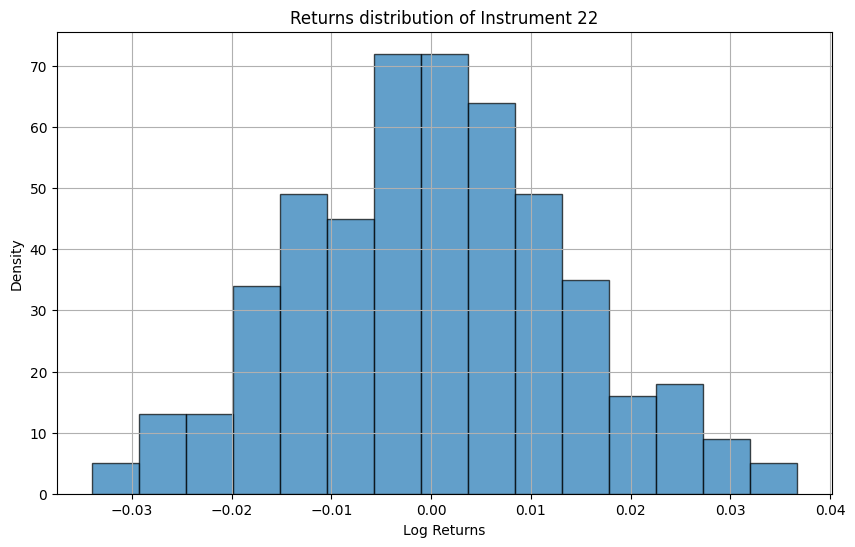

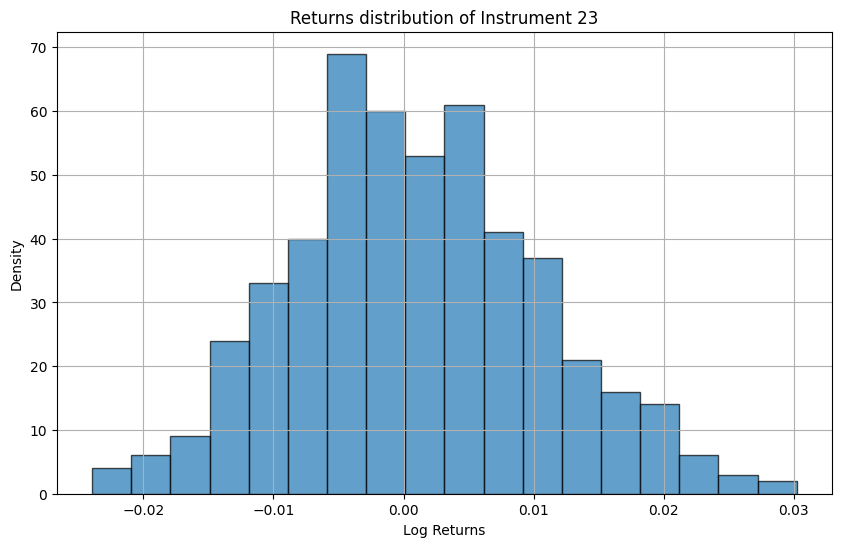

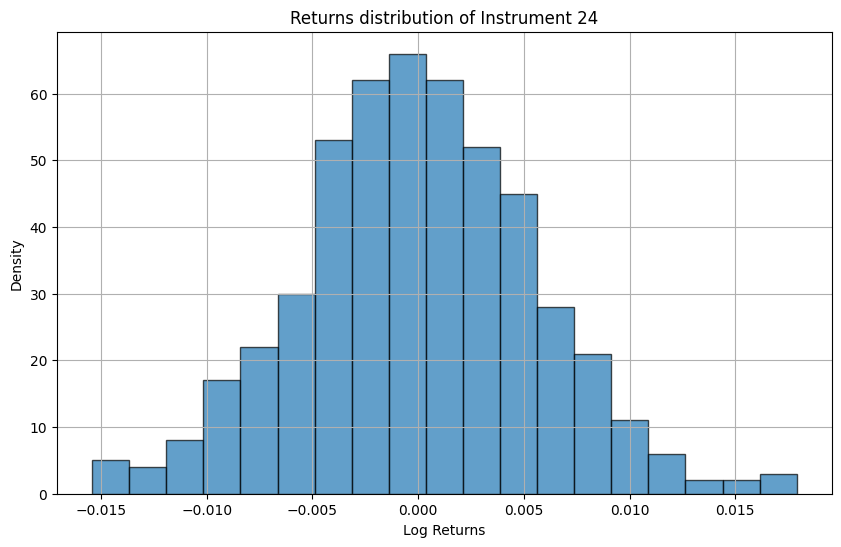

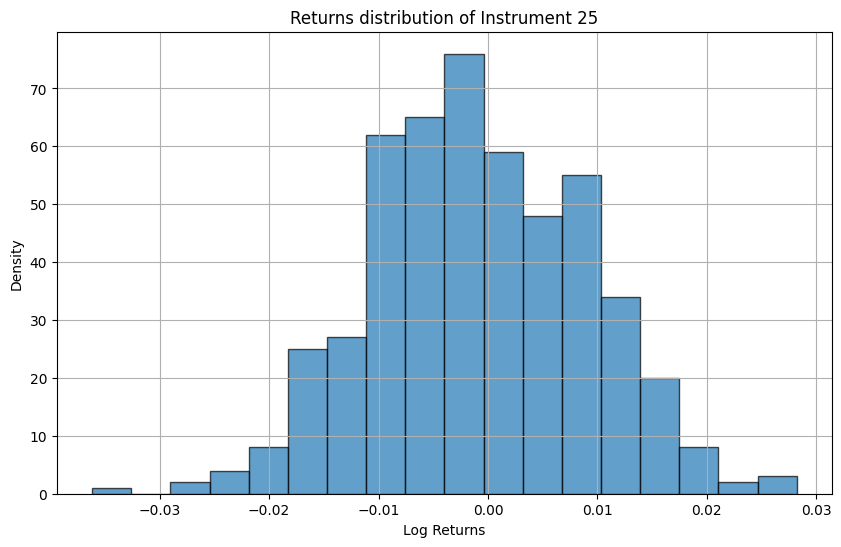

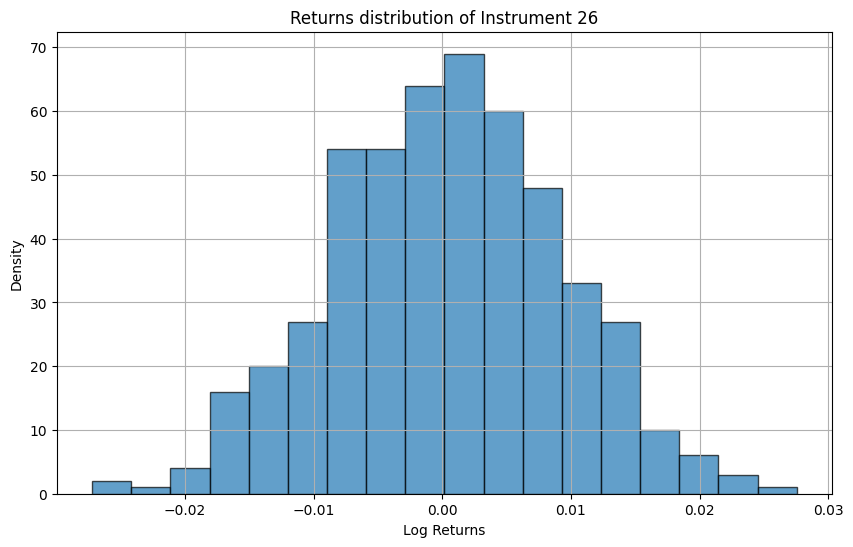

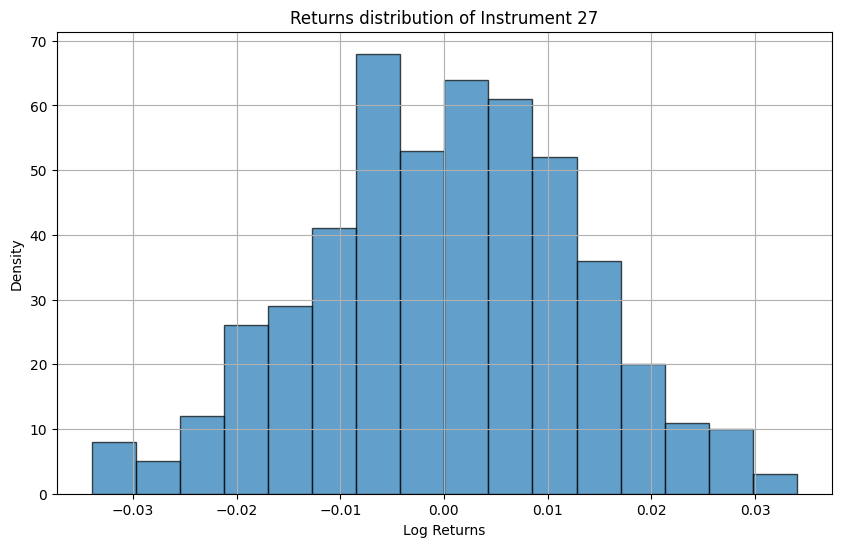

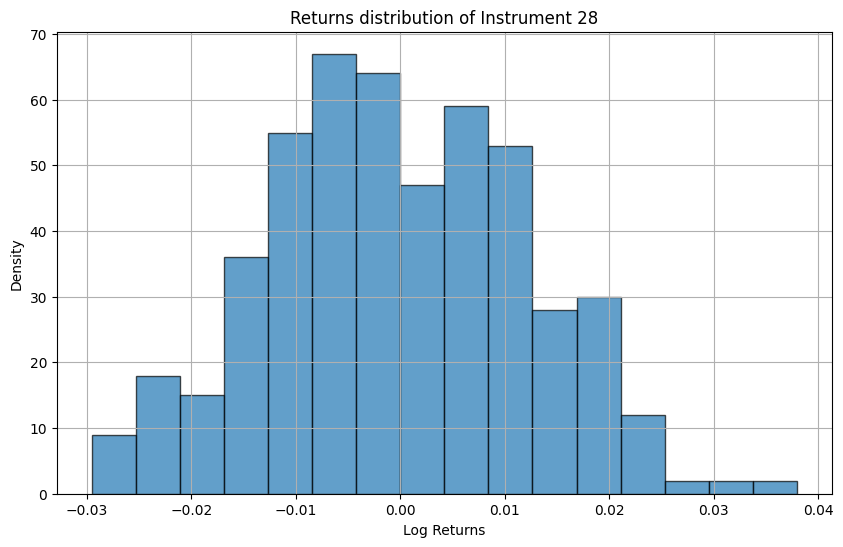

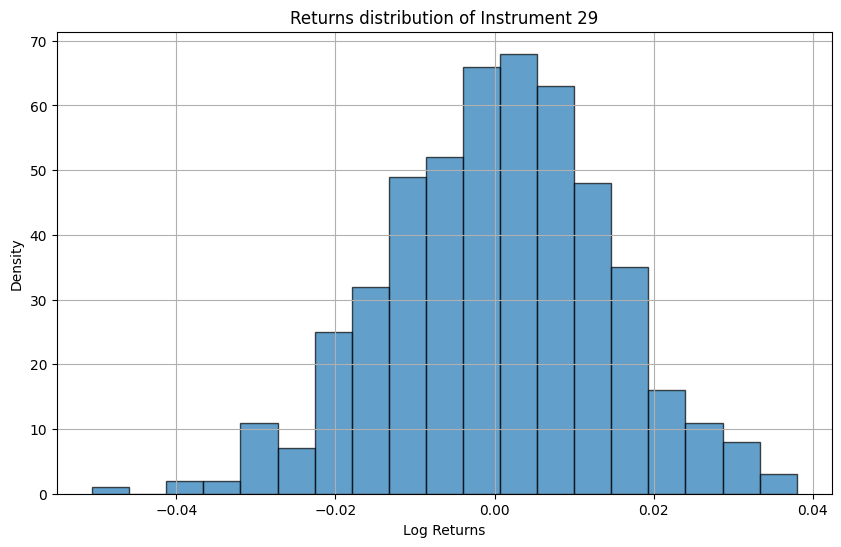

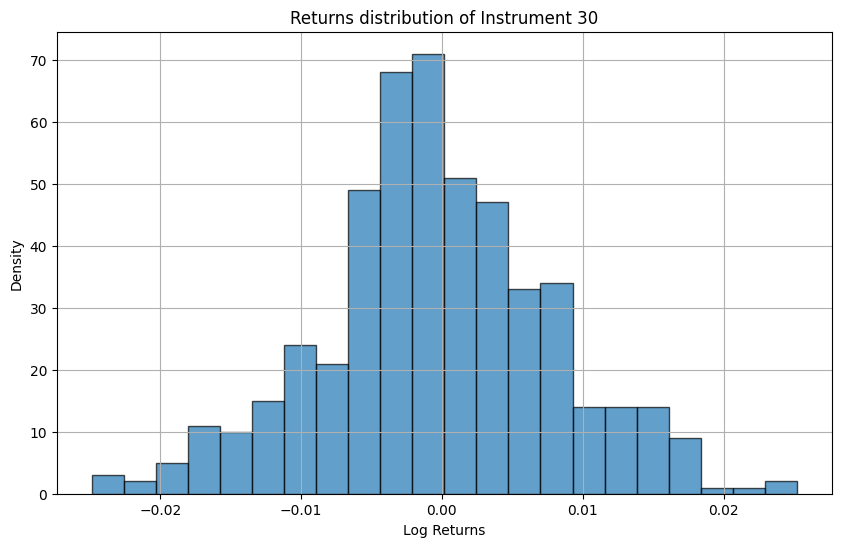

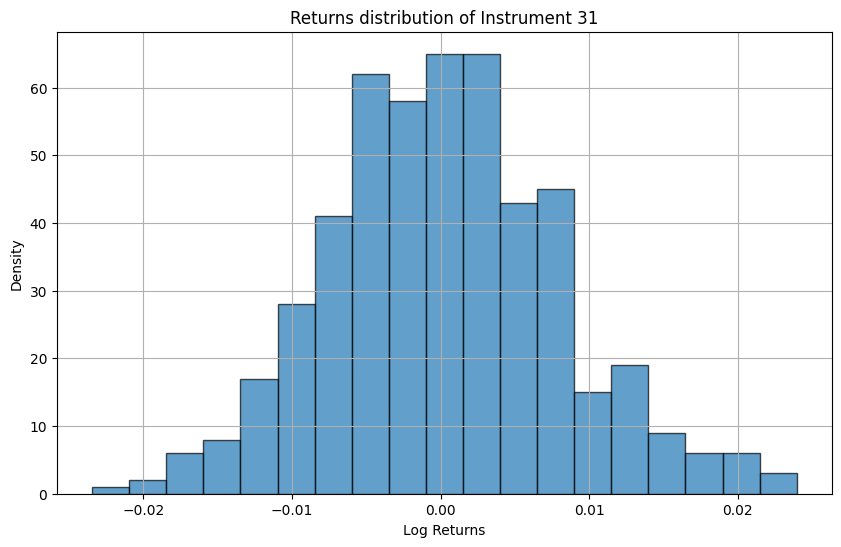

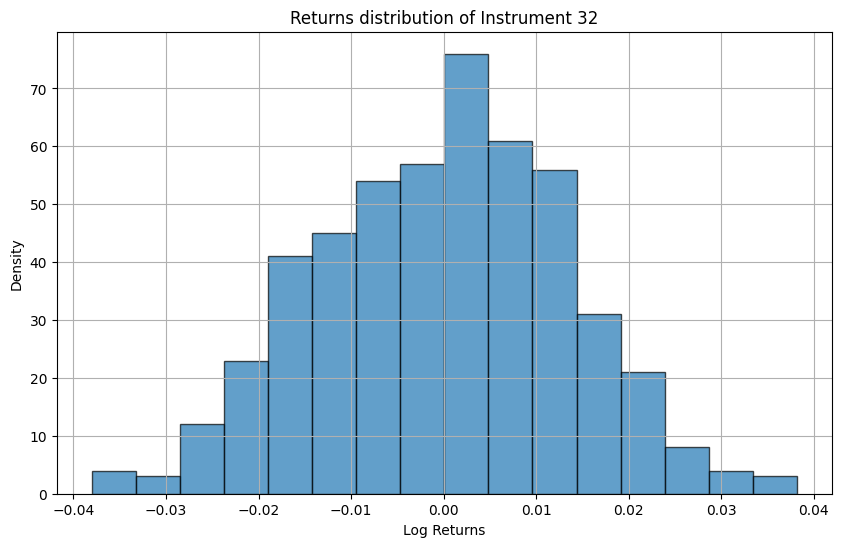

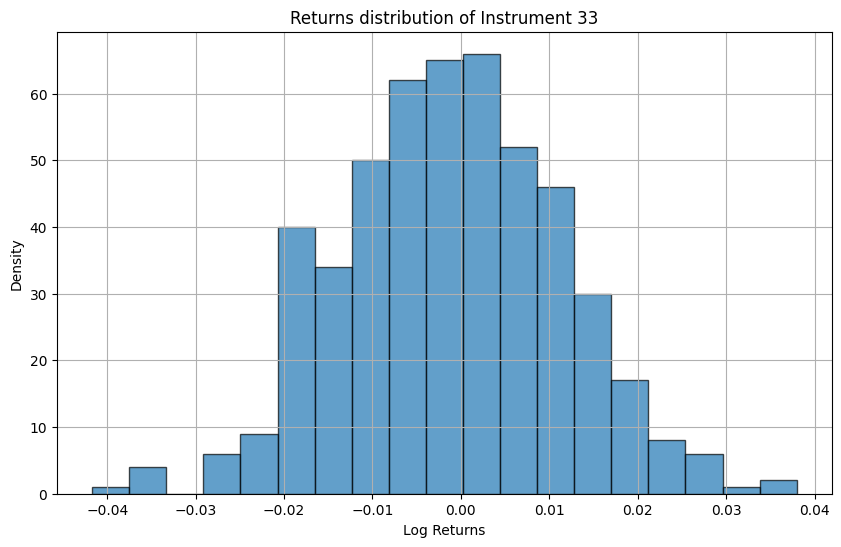

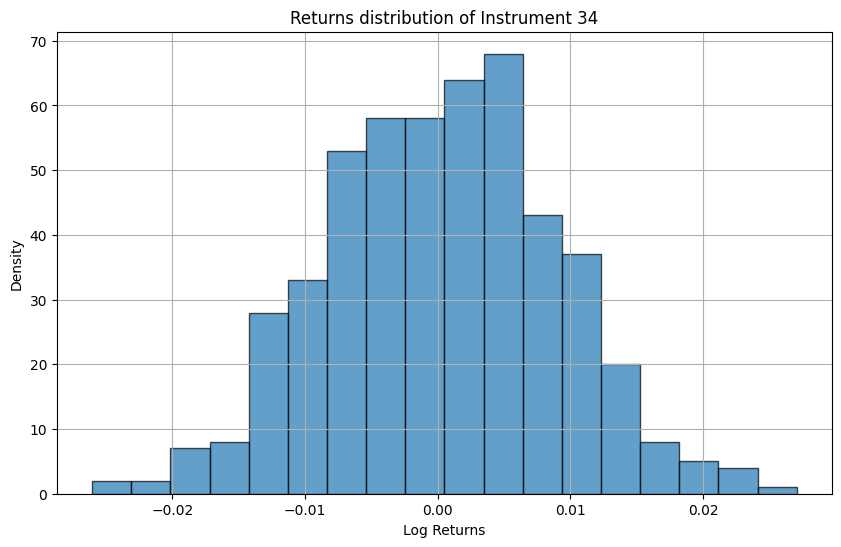

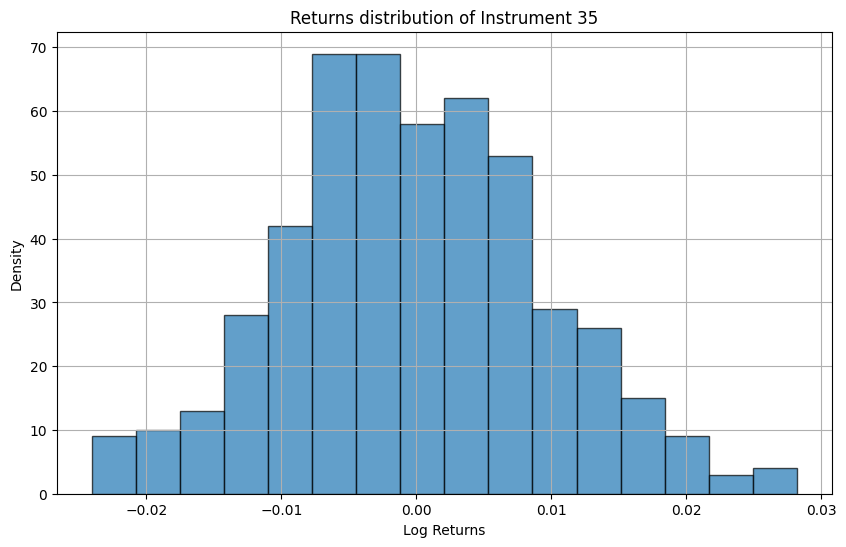

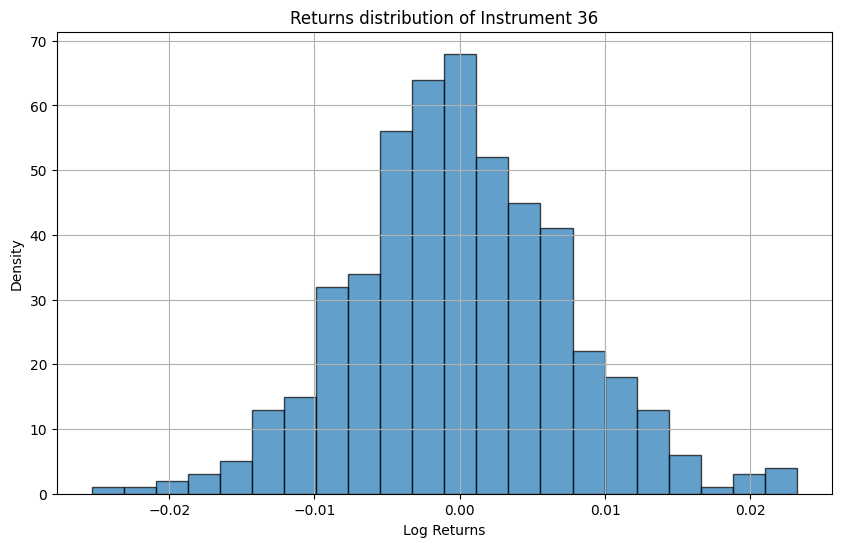

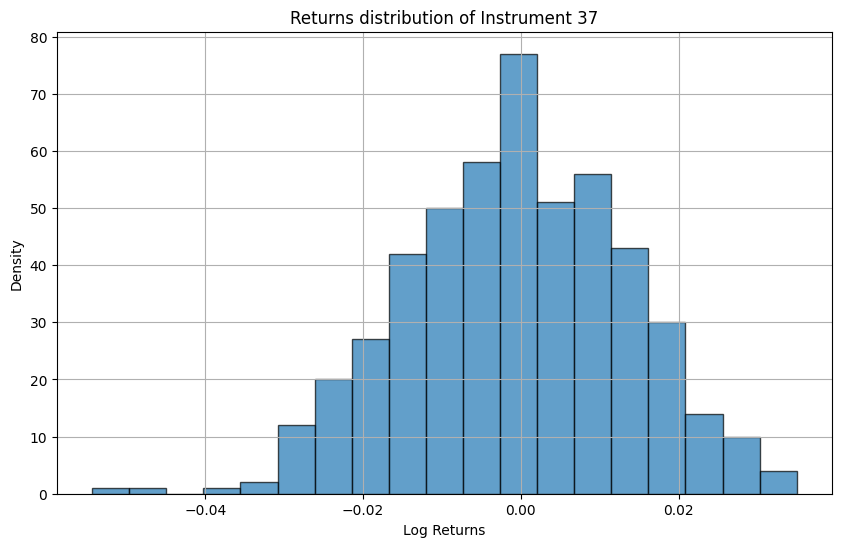

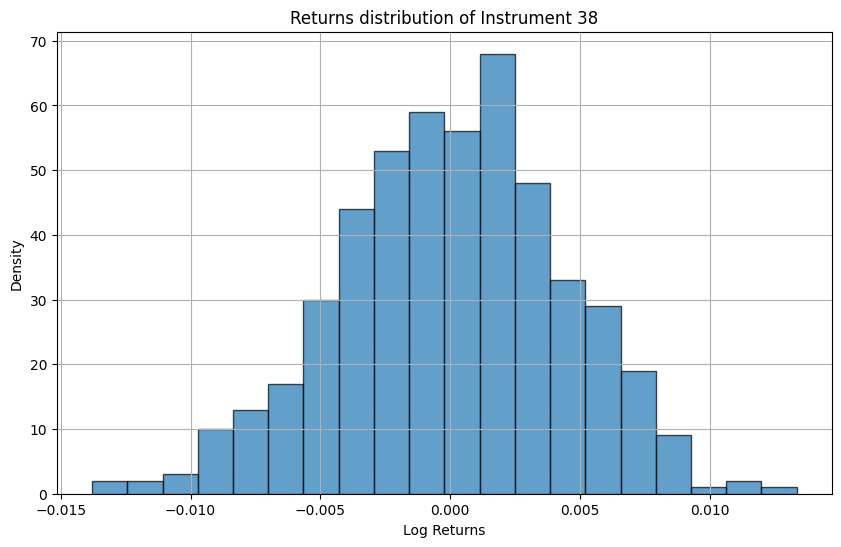

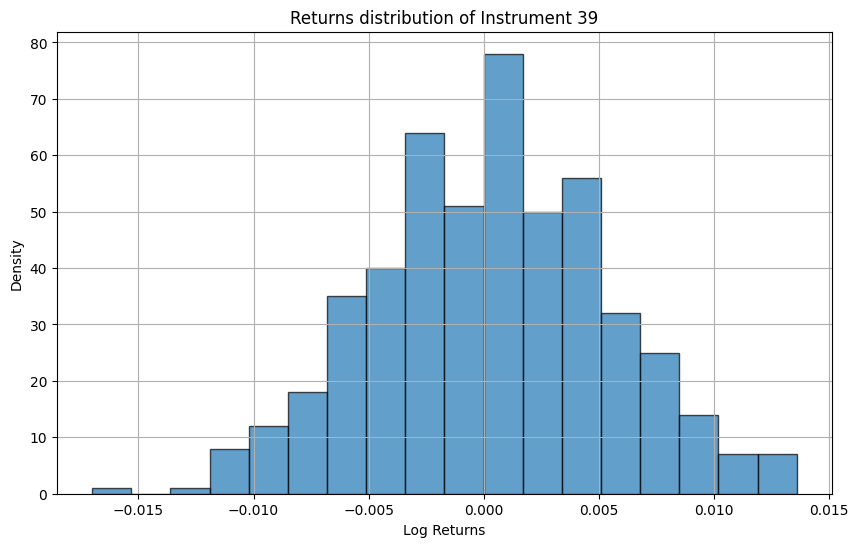

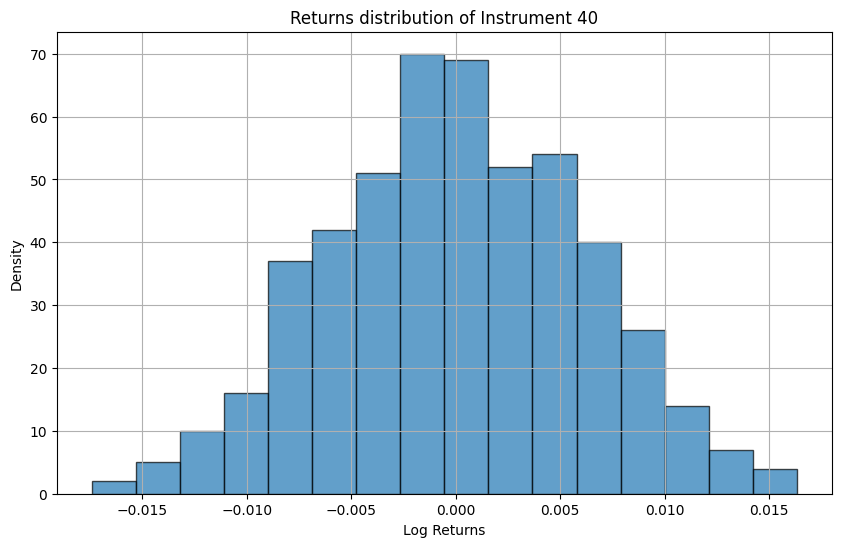

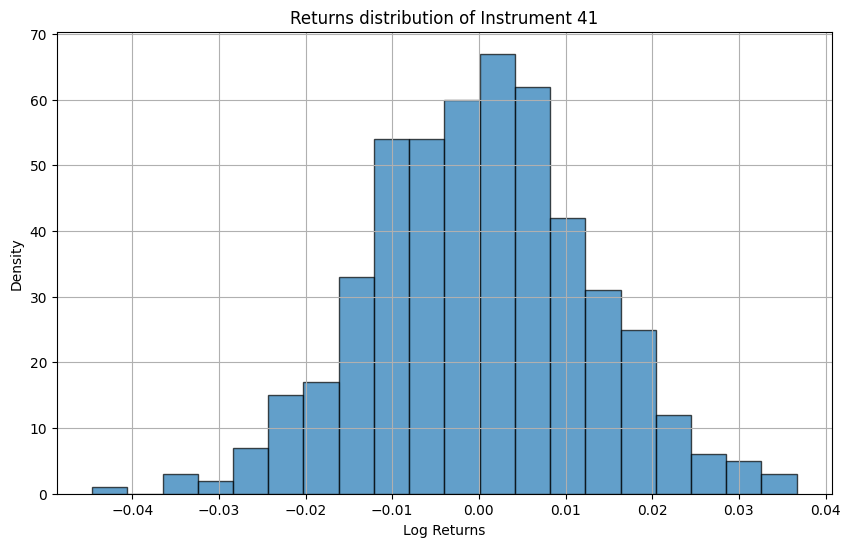

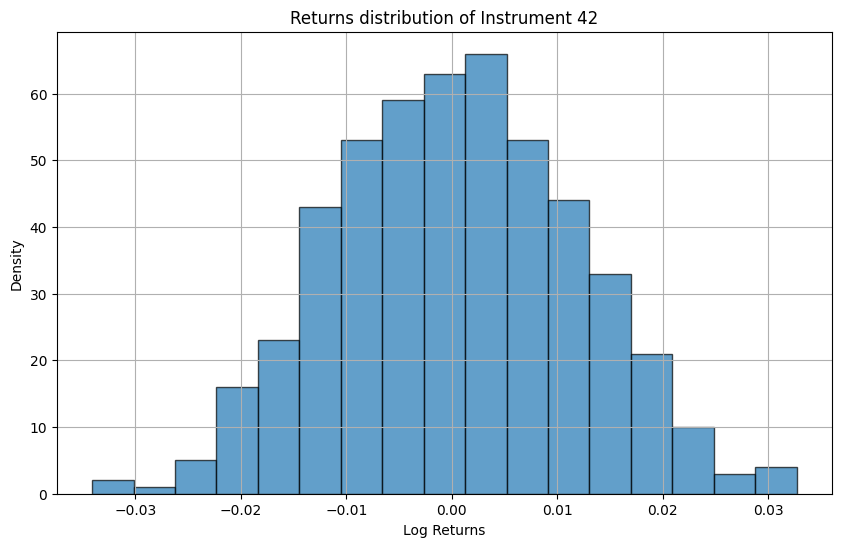

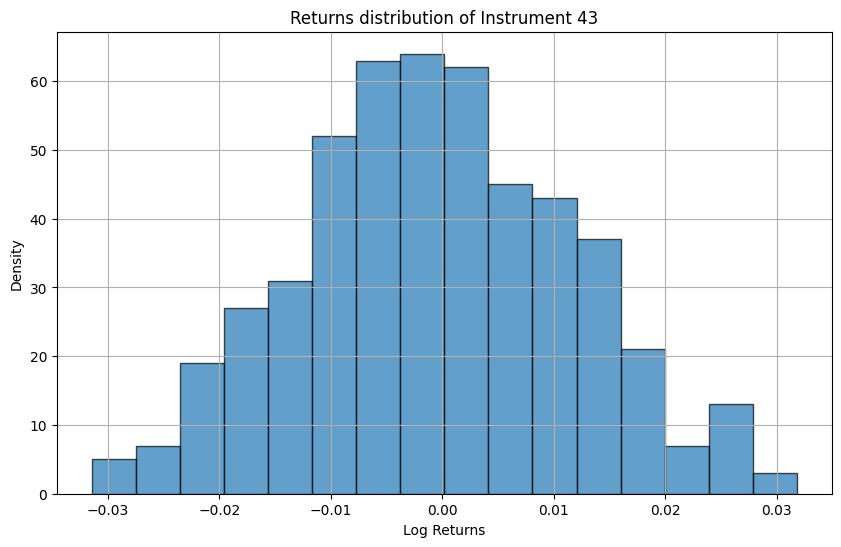

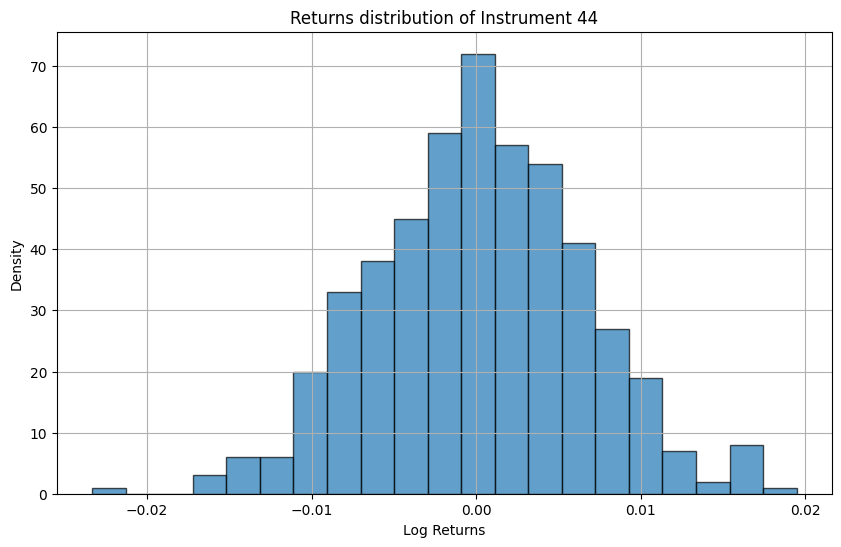

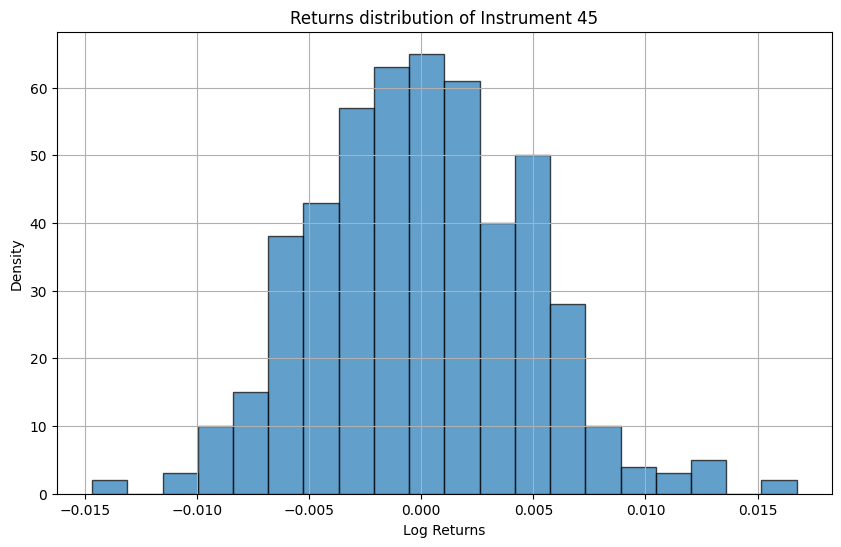

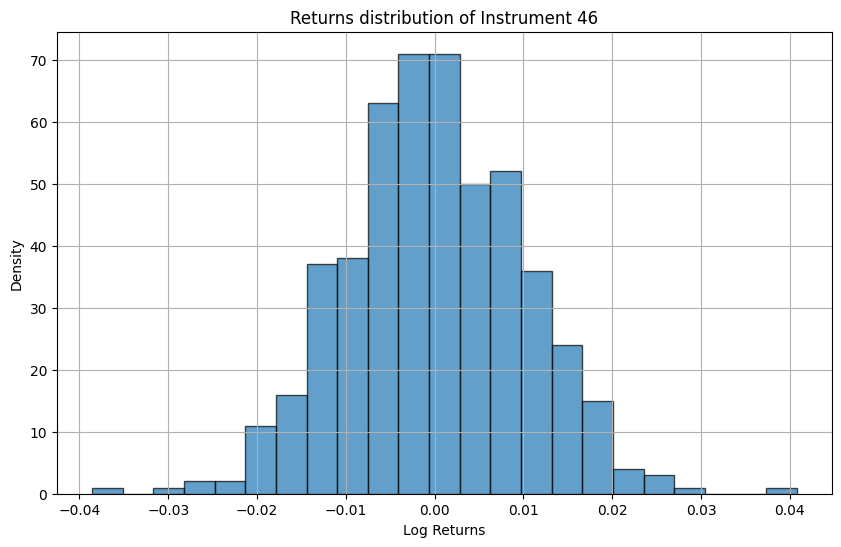

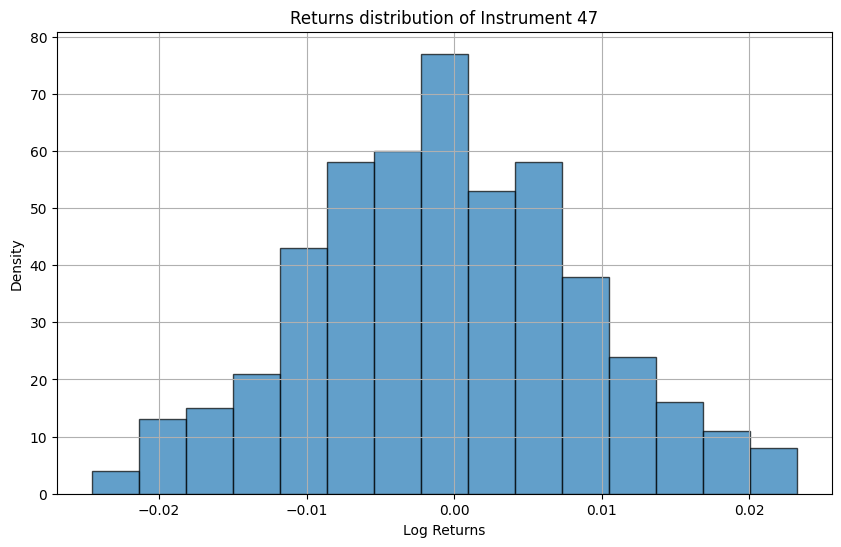

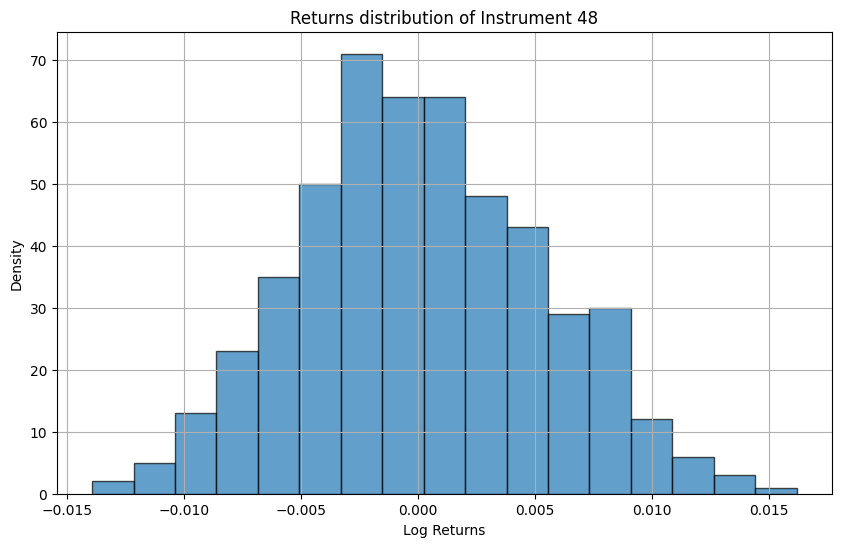

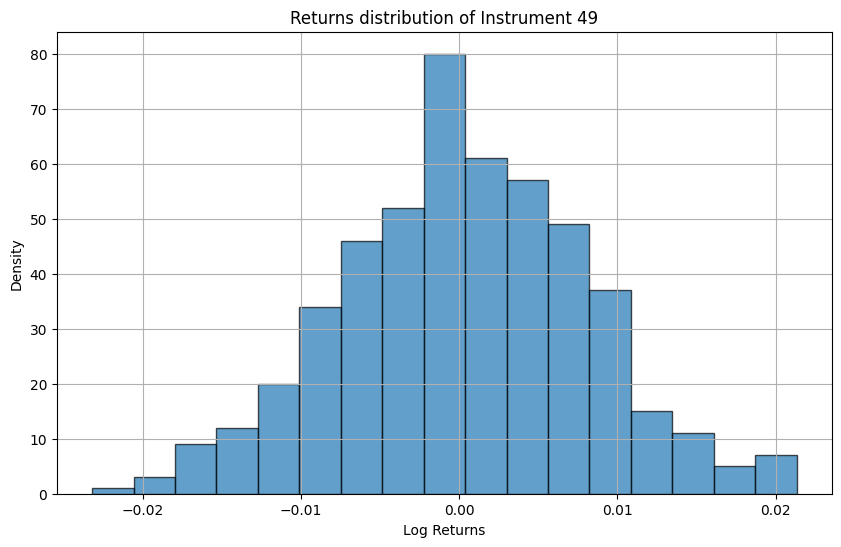

In [43]:
for instrument_no in instrument_nos:
	plt.figure(figsize=(10,6))
	plt.hist(log_returns[instrument_no], bins="auto", alpha=0.7, edgecolor="black")
	plt.xlabel("Log Returns")
	plt.ylabel("Density")
	plt.title(f"Returns distribution of Instrument {instrument_no}")
	plt.grid(True)
	plt.show()


We now list a few signals/features we can use in our strategy implementation

In [44]:
signals: Dict[str, List[float | int]] = {}
signals["Instrument No."] = instrument_nos

# 1. Calculate statistical significance of drift
signals["Statistical Significance of Drift"] = (instrument_features_df["Drift"].values /
	(instrument_features_df["Volatility"].values / np.sqrt(500)))

# 2. Calculate Kelly Criterion
signals["Kelly Criterion"] = (instrument_features_df["Drift"].values / 
  (instrument_features_df["Volatility"].values ** 2))

# 3. Calculate Drift vs Diffusion
signals["Drift vs. Diffusion"] = (
		(instrument_features_df["Volatility"].values
		 ** 2)
		/ (instrument_features_df["Drift"].values ** 2)
)

signals_df: DataFrame = pd.DataFrame(signals)
print(signals_df.to_string(index=False))

 Instrument No.  Statistical Significance of Drift  Kelly Criterion  Drift vs. Diffusion
              0                          -1.130123       -11.184175           391.487824
              1                          -1.363173       -10.249815           269.071744
              2                          -0.957003        -3.272075           545.937773
              3                           0.528862         2.091645          1787.659838
              4                          -1.374224        -9.029591           264.761558
              5                          -0.212596        -1.656979         11062.636529
              6                          -1.661518        -6.576100           181.117360
              7                           0.934984         3.780944           571.955312
              8                          -0.421659        -1.375688          2812.201120
              9                           0.378892         1.322253          3482.888803
             10      